In [1]:
import itertools
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import pdb

In [18]:
data = pd.read_csv('case_8.csv')
## test the code with a subset of the data
data = data[0:100]
target = data['target']
data.drop(['target', 'ID'],inplace=True, axis=1)

In [19]:
### Find cols with over 20 categories 
cat_data = data.loc[:, data.dtypes == object]

col_bin_candidates = dict()
for col in cat_data:
    category_count = len(data[col].value_counts())
    if category_count > 20:
        col_bin_candidates[col] = category_count
        
col_bin_candidates

{'v22': 95, 'v56': 33, 'v125': 48}

The first step in processing the data is splitting the target column out and droping the `ID` column which adds no value to the analysis. Once this is done, an investigation is done for any categorical columns that contains a high number of categories. The categorical column counts show that column `v22` has 18210 distinct values. 

This can be a problem after one hot encoding as will be done farther in the analysis because it would lead to a very large, sparse matrix. In the next code block the counts for categorical variables with over 20 categories are plotted.

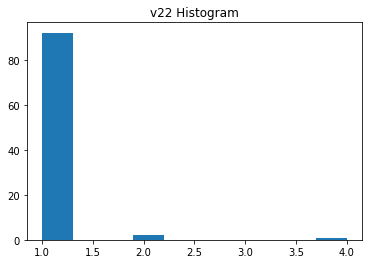

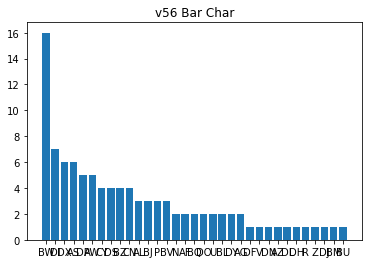

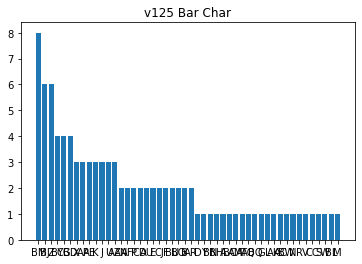

In [20]:
### Visualized values for cols with over 10 categories
for col in col_bin_candidates:
    counts = data[col].value_counts().to_frame()
    
    fig = plt.figure()
    if len(counts) < 50:
        plt.title("{c} Bar Char".format(c=col)) 
        plt.bar(counts.index, counts[col])
    else:
        plt.title("{c} Histogram".format(c=col)) 
        plt.hist(counts[col])

In the bar charts above it seems that columns `v22` and `v113` don't have an excessive number of categories and have some spread so will be kept unaltered. Column `v125` has over 100 categories but many appear to have at least 1000 samples so this column will also be kept as unaltered. Columns `v56` and `v22` have a large categories of users with a relatively low number of users and will likely need binning. 

In [21]:
### Look for bin point col v22
data['v22'].value_counts()[0:50]

AGDF    4
QKP     2
VZF     2
XDX     1
QU      1
QHQ     1
BMF     1
IEE     1
JOF     1
AV      1
ADDF    1
YGJ     1
NKE     1
AYX     1
ACTZ    1
VVI     1
FLR     1
ABQS    1
KEM     1
AHPP    1
AGXX    1
PWR     1
DOB     1
IIP     1
AGVV    1
QKI     1
GOI     1
RHD     1
CBS     1
MQE     1
ABJD    1
BZT     1
MVD     1
ZHA     1
SGN     1
KBM     1
AIN     1
AFJK    1
AGRM    1
XFE     1
UDX     1
HUU     1
BWJ     1
FQ      1
ABPH    1
XQU     1
NFD     1
NGS     1
AHBW    1
AAJR    1
Name: v22, dtype: int64

Inspection of the first 50 the value counts for column `v22` shows a dropoff in value counts after the value `HUU` with a count of 146.

In [22]:
### Look for bin point col v56
data['v56'].value_counts()[0:50]

BW    16
DI     7
DX     6
AS     6
DP     5
AW     5
CY     4
DS     4
BZ     4
CN     4
AL     3
BJ     3
P      3
BV     3
N      2
AF     2
BQ     2
DO     2
U      2
BL     2
DY     2
AG     2
DF     1
V      1
DN     1
AZ     1
DL     1
DH     1
R      1
Z      1
DJ     1
BM     1
BU     1
Name: v56, dtype: int64

A similar inspection of column `v56` shows a sharp dropoff after value `CF` woth 141 value counts. Based on the above, the next two code blocks will bin all categories with value counts below 140 for columns `v22` and `v56`.

In [27]:
#### Bin categorical colunm based on cutoff for minmum value count
def bin_df_col(df, col, cutoff):
    vc = df[col].value_counts().to_frame()
    below_cutoff = vc[vc[col] < cutoff].index
    df.loc[(df[col].isin(below_cutoff)), col] = 'Other'
    
    return df

In [28]:
### Bin cols based on observations above
data = bin_df_col(data, 'v22', 140)
data = bin_df_col(data, 'v56', 140)

The `bin_df_col()` function takes the 140 cutoff and sets all categories with a value counts below the cutoff to `Other`.

In [29]:
### One hot encode
data_ohe = pd.get_dummies(data)
data_ohe.shape

(100, 269)

After binning, the data is one hot encoded such that each of the categories for all categorical features are split into their own binary indicator variable. After one hot encoding, the final feature set consists of 453 features.

In [41]:
def run_clf_grid(data, clf_hyper_grid, return_best=False, boost_rounds=None, clf=None):
    clf_scores = []

    param, param_values = zip(*clf_hyper_grid.items())
    param_list = [dict(zip(param, param_value)) for param_value in itertools.product(*param_values)]

    for params in param_list:
        if clf:
            score = run_clf(clf, data, params)
            clf_scores.append(score)
        else:
            for boost_round in boost_rounds:
                score = run_xgb(data, params, boost_round)
                clf_scores.append(score)

    clf_scores.sort(key=lambda x: x['log_loss'])
    if return_best:
        clf_scores = [clf_scores[0]]

    return clf_scores

The `run_clf_grid()` above will be used to tune the hyperparamters of the models used to run the classification. The data is passed along with a dictionary of parameters to tune. The keys of the dictionary are the parameter name and the values are a list of parameter values to try. The itertools.product function is used to generate all possible combinations of parameters and the provided classifier is run using the `run_clf()` function with every parameter combination (if no classifier is provided, xgboost is used). The scores for each parameter combination are returned.

In [42]:
def run_clf(a_clf, data, clf_hyper):
    M, L, n_folds = data # unpack data container
    kf = KFold(n_splits=n_folds) # Establish the cross validation
    scores = []

    for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
        clf = a_clf(**clf_hyper) # unpack parameters into clf is they exist
        clf.fit(M.iloc[train_index], L.iloc[train_index])

        pred = clf.predict(M.iloc[test_index])
        score_log_loss = log_loss(L.iloc[test_index], pred)
        pred[pred<0.5] = 0
        pred[pred>=0.5] = 1
        score_acc = accuracy_score(L.iloc[test_index], pred)
        scores.append((score_log_loss, score_acc))

    ret = {
        'clf': str(clf),
        'log_loss': sum([score[0] for score in scores]) / float(len(scores)),
        'accuracy': sum([score[1] for score in scores]) / float(len(scores))
    }

    return ret


Above is the `run_clf()` called by `run_clf_grid()`. This funciton does k-fold cross validation, unpacks the hyperparamters provided, and passes them to the provided classifier. The classifier is fit on each train fold and the log loss is calculated between the predictions on the test fold and the target labels for each fold. These are averaged to provide the k-fold log loss. 

The formula for the log loss is LogLoss = - \frac{1}{n} \sum\limits_{i=1}^n [y_i \cdot log_e(\hat{y_i}) + (1-y_i) \cdot log_e(1-\hat{y_i}) ]
where y is the label of the target and smaller is better.

In [43]:
def run_xgb(data, clf_hyper, boost_round):
    M, L, n_folds = data # unpack data container
    kf = KFold(n_splits=n_folds) # Establish the cross validation
    scores = []

    for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
        xgtrain = xgb.DMatrix(M.iloc[train_index].values, L.iloc[train_index].values)
        xgtest = xgb.DMatrix(M.iloc[test_index].values, L.iloc[test_index].values)
        
        clf = xgb.train(
            clf_hyper,
            xgtrain,
            num_boost_round=boost_round,
            verbose_eval=True,
            maximize=False
        )
        
        pred = clf.predict(xgtest, ntree_limit=clf.best_iteration)
        score_log_loss = log_loss(L.iloc[test_index], pred)
        pred[pred<0.5] = 0
        pred[pred>=0.5] = 1
        score_acc = accuracy_score(L.iloc[test_index], pred)
        scores.append((score_log_loss, score_acc))

    ret = {
        'params': clf_hyper,
        'boost_round': boost_round,
        'log_loss': sum([score[0] for score in scores]) / float(len(scores)),
        'accuracy': sum([score[1] for score in scores]) / float(len(scores))
    }

    return ret

Above is the the same function for xgboost, which requires processing into its ow data type and has different syntax for fitting the model. We still do k-fold cross validation and average the log loss of the folds.

In [44]:
xgboost_hyper = { 
   "objective": ["binary:logistic"],
   "booster": ["gbtree"],
   "eval_metric": ["logloss"],
   "eta": [0.001, 0.01, 0.1], 
   "subsample": [.25, .5],
   "colsample_bytree": [0.25, 0.5],
   "max_depth": [2,4]
}
clf_data = (data_ohe, target, 3)
xgb_scores = run_clf_grid(clf_data, xgboost_hyper, boost_rounds=[30,60])

In [45]:
xgb_scores[0]

{'params': {'objective': 'binary:logistic',
  'booster': 'gbtree',
  'eval_metric': 'logloss',
  'eta': 0.1,
  'subsample': 0.5,
  'colsample_bytree': 0.5,
  'max_depth': 2},
 'boost_round': 30,
 'log_loss': 0.5169844735199082,
 'accuracy': 0.7290552584670231}

Finally, XGBoost is run on the data with various parameters with 3 folds using `run_clf_grid()`. XGBoost is an optimized gradient boosting machine. Boosting is a technique where the residual of the model are iteratively run as the new targets of the model so that the model learns from the mistakes of previous iterations. 

Here XGBoost is run with a deciions tree and the parameters being tuned are:
- `eta`: learning rate for how aggressively the boosting adjusts the model between iterations
- `subsample`: the percent of the training data to subsample each iteration to avoid overfitting
- `colsample_bytree`: the percent of columns that are condisered at each level of the tree
- `max_depth`: the maximum depth of the decision tree
- `boost_rounds`: how many iterations of boost the model will run

Notably, the log loss the the XGBoost for a number of paramter sets is below 0.6.

In [46]:
r_clf = RandomForestClassifier
r_clf_hyper_grid = {
    'n_estimators': [10, 100],
    'max_depth': [2, 4],
    'max_features': [None, 'sqrt'],
}
rf_scores = run_clf_grid(clf_data, r_clf_hyper_grid, clf=r_clf)

In [47]:
rf_scores

[{'clf': "RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=10)",
  'log_loss': 8.321923983894372,
  'accuracy': 0.7590612002376709},
 {'clf': "RandomForestClassifier(max_depth=2, max_features='sqrt')",
  'log_loss': 8.670808589877614,
  'accuracy': 0.7489601901366606},
 {'clf': "RandomForestClassifier(max_depth=4, max_features='sqrt')",
  'log_loss': 8.670808589877614,
  'accuracy': 0.7489601901366606},
 {'clf': 'RandomForestClassifier(max_depth=2, max_features=None, n_estimators=10)',
  'log_loss': 9.00939981450452,
  'accuracy': 0.7391562685680334},
 {'clf': "RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=10)",
  'log_loss': 9.009424044729679,
  'accuracy': 0.7391562685680332},
 {'clf': 'RandomForestClassifier(max_depth=2, max_features=None)',
  'log_loss': 9.71743817760218,
  'accuracy': 0.7186571598336303},
 {'clf': 'RandomForestClassifier(max_depth=4, max_features=None)',
  'log_loss': 10.056029402229086,
  'accuracy': 0.7088532382650029

The next algorithm under considersation is the Random Forest Classifier. Random Forests are also tree base, however they are built in parallel. A number of different decision trees are built using subset of the data and new data is fed to the resulting set of trees and they vote on the new classification.

The hyper parameters being tuned are the number of trees, the max depth of the trees, and the number of features considered when looking for a split. 

The log loss for random forest is consistently in the 7.7-8.25, quite a bit worse than XGBoost above.

In [16]:
svc_clf = LinearSVC
svc_clf_hyper_grid = {
    'C': [0.1, 1, 10],
    'tol': [0.01, 0.0001, 0.00001],
    'max_iter': [5000]
}
svc_scores = run_clf_grid(clf_data, svc_clf_hyper_grid, clf=svc_clf)

/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear f

In [17]:
svc_scores

[{'clf': 'LinearSVC(C=0.1, max_iter=5000)', 'score': 7.920575587348921},
 {'clf': 'LinearSVC(C=0.1, max_iter=5000, tol=0.01)',
  'score': 7.922086031547568},
 {'clf': 'LinearSVC(C=0.1, max_iter=5000, tol=1e-05)',
  'score': 7.92450426562787},
 {'clf': 'LinearSVC(C=1, max_iter=5000)', 'score': 8.229649398992613},
 {'clf': 'LinearSVC(C=10, max_iter=5000, tol=0.01)',
  'score': 8.324511627323252},
 {'clf': 'LinearSVC(C=1, max_iter=5000, tol=0.01)',
  'score': 12.211253542686412},
 {'clf': 'LinearSVC(C=1, max_iter=5000, tol=1e-05)',
  'score': 12.872297181102917},
 {'clf': 'LinearSVC(C=10, max_iter=5000, tol=1e-05)',
  'score': 13.447533730494486},
 {'clf': 'LinearSVC(C=10, max_iter=5000)', 'score': 14.099811809806676}]

Finally, the linear SVC is run. This is the linear version of SVM where linear boundaries seperate the data based on the seperation with the largest margin. The performance in terms of log loss was similar to random forest, but XGBoost was much better.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_ohe, target, test_size=0.33, random_state=42)
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values, y_test.values)

In [18]:
print('Fit the model...')
# XGBoost params:
xgboost_params = { 
   "objective": "binary:logistic",
   "booster": "gbtree",
   "eval_metric": "logloss",
   "eta": 0.01, 
   "subsample": 0.5,
   "colsample_bytree": 0.5,
   "max_depth": 3
}
boost_round = 50
clf = xgb.train(xgboost_params,xgtrain,num_boost_round=boost_round,verbose_eval=True,maximize=False)

Fit the model...


In [19]:
#Make predict
print('Predict...')
test_preds = clf.predict(xgtest, ntree_limit=clf.best_iteration)
print(log_loss(y_test,test_preds))
print(accuracy_score(y_test,np.rint(test_preds)))

Predict...
0.5840175097972852
0.7726501616922017
